In [ ]:
import os

from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v
#!google-drive-ocamlfuse drive

cwd = os.getcwd()

#### Changez le chemin ci-dessous vers votre repertoire dans votre googledrive
##############################################################################

monchemin = 'drive/My Drive/Colab Notebooks/M2I3A/PSTALN/projet'

dir_path  = os.path.join(cwd, monchemin)
dirs = os.listdir(dir_path)
os.chdir(dir_path)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Recupération des données bibliovid

In [ ]:
import json

In [ ]:
with open('bibliovid.json') as json_data:
    data_dict = json.load(json_data)

In [ ]:
print("Nombres d'article:",len(data_dict))
print("Avec ces informations pour chacun:")
for i in data_dict:
    for cle, val in i.items():
        print(cle)
    break

Nombres d'article: 682
Avec ces informations pour chacun:
id
slug
title
has_other_authors
impact_factor
goals_plain
verbose_date
authors
document_link
specialties
category
journal
link
results
synthesis
strength_of_evidence_details
goals
methods
pubmed_id
doi
abstract
topics
author_list
publication_date


In [ ]:
print('Un exemple d\'articles:')
print(data_dict[1])

Un exemple d'articles:
{'id': 756, 'slug': 'optimal-covid-19-epidemic-control-until-vaccine-deployment', 'title': 'Optimal COVID-19 epidemic control until vaccine deployment', 'has_other_authors': True, 'impact_factor': {'id': 4, 'name': 'Indéterminé', 'posts_count': 96, 'color': 'gray', 'order': 4}, 'goals_plain': 'L\'objectif de cette étude est de déterminer des stratégies permettant le contrôle d\'une épidémie limitant au maximum le nombre de morts dûs à cette épidémie, ainsi que le coût associé à cette politique de contrôle. En particulier, l\'article prend en compte l\'augmentation de la mortalité associée à une saturation du système de santé. Différentes stratégies "réalistes" sont également considérées, comme une politique de contrôle mise à jour à intervalles réguliers, une politique de contrôle constante, ou une alternance entre période de contrôle maximal (type confinement) et minimal.', 'verbose_date': '22.07.2020', 'authors': 'Djidjou-Demasse R', 'document_link': 'https://w

In [ ]:
print('Comment sont représentés les spécialités')
print(data_dict[28]['specialties'])

Comment sont représentés les spécialités
[{'id': 21, 'name': 'Confinement/Déconfinement'}]


In [ ]:
print('Un exemple d\'abstract')
print(data_dict[0]['abstract'])

Un exemple d'abstract
Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitaliz

In [ ]:
specialties = {} # dictionnaire id -> specialité
nb_per_spe = {}  # nombres d'articles par spécialité

In [ ]:
ind_spe = 0
for article in data_dict:
    for spe in article['specialties']:
        if spe['name'] not in specialties.keys():
            specialties[spe['name']] = ind_spe
            nb_per_spe[spe['name']] = 0
            ind_spe += 1
        nb_per_spe[spe['name']] += 1

In [ ]:
LABELS = list(specialties.keys())
LABELS

['Anesthésie-Réanimation',
 'Infectiologie',
 'Transversale',
 'Immunité',
 'Virologie',
 'Confinement/Déconfinement',
 'Pédiatrie',
 'Pneumologie',
 'Gynécologie Obstétrique',
 'Gériatrie',
 'Cardiologie et maladies métaboliques',
 'Hygiène',
 'Hépato-gastro-entérologie',
 'Neurologie',
 'Radiologie',
 'Dermatologie',
 'Hématologie',
 'Psychiatrie',
 'Néphrologie']

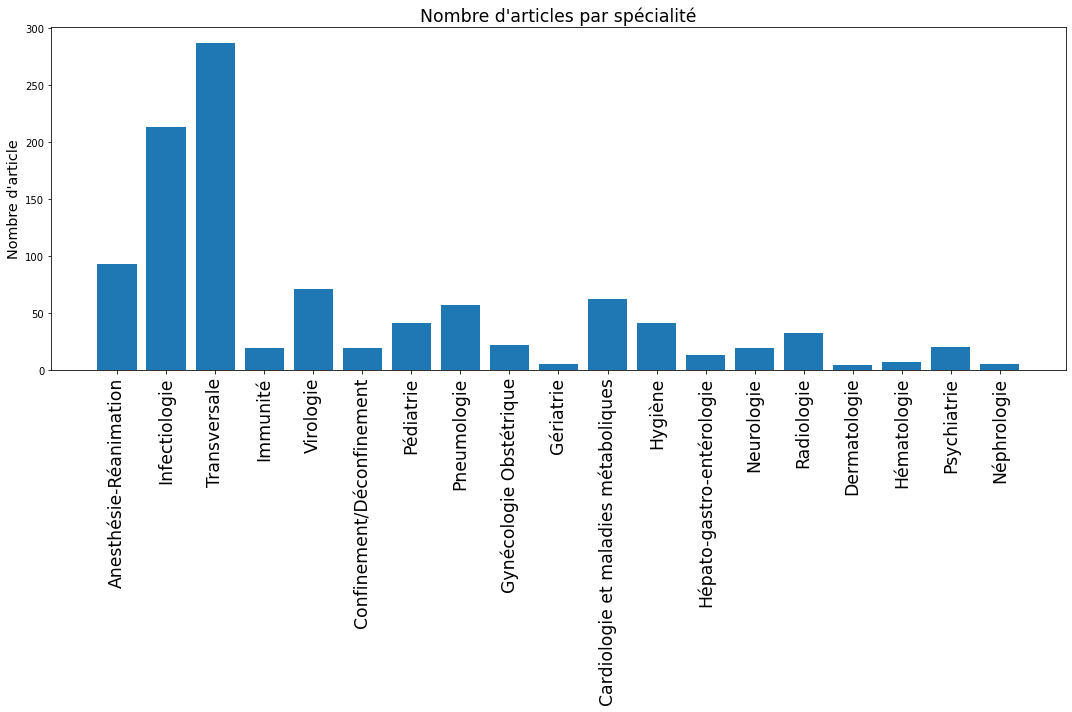

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(15,10))
plt.bar(np.arange(19), nb_per_spe.values())
plt.title('Nombre d\'articles par spécialité',size='xx-large')
plt.ylabel('Nombre d\'article',size='x-large')
plt.xticks(np.arange(19), nb_per_spe.keys(), rotation='vertical',size='xx-large')
plt.tight_layout()
fig.savefig('nbre_par_spe.png')
plt.show()

On remarque que certaines spécialités sont très peu représentés (Dermatologie, Gériatrie, Néphrologie), ce qui risque de poser problèmes pour des modèles entrainés depuis 0.

Au contraire, nous avons beaucoup d'exemples pour la spécialité "Transversale", et ce n'est sûrement pas très pertinent car cette spécialité va finalement en englober plusieurs et cela risque de "brouiller" nos classifieurs. On pourrait par exemple mettre la spécialité Transversale si on a déjà prédit 2 spécialité pour l'article.

# Préparation des données

On va récupérer les données qui nous intéresse.

In [ ]:
import utils
texts, Y = utils.get_data(data_dict, get_abstract = False)

In [ ]:
print("y shape:",Y.shape)

y shape: (682, 19)


Sur les 682 articles que l'on a, on en a 207 qui n'ont pas d'abstract. On va tenter dans un premier temps de prédire la classe seulement avec le titre afin que toutes les données fassent à peu près la même longueur.

Nous allons utiliser les représentations CountVectorizer et TfidVectorizer.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(stop_words="english", max_features=2000, min_df=1)  #max_df
vect.fit(texts)
vect2 = TfidfVectorizer(stop_words="english", max_features=2000, min_df=1)  #max_df
vect2.fit(texts)

TfidfVectorizer(max_features=2000, stop_words='english')

In [ ]:
print("TfidVectorizer")
print("Vocabulary size: {}".format(len(vect2.vocabulary_)))
print("Vocabulary content:\n {}".format(vect2.vocabulary_))

TfidVectorizer
Vocabulary size: 1792
Vocabulary content:
 {'body': 220, 'mass': 978, 'index': 809, 'risk': 1411, 'intubation': 868, 'death': 420, 'sars': 1429, 'cov': 391, 'infection': 821, 'retrospective': 1399, 'cohort': 307, 'study': 1566, 'optimal': 1120, 'covid': 393, '19': 21, 'epidemic': 559, 'control': 359, 'vaccine': 1725, 'deployment': 439, 'contact': 348, 'rate': 1319, 'equilibrium': 565, 'view': 1750, 'hydroxychloroquine': 744, 'treatment': 1673, 'prophylaxis': 1278, 'non': 1092, 'human': 739, 'primates': 1254, 'infectivity': 824, 'profile': 1266, 'correction': 378, 'mrna': 1039, 'preliminary': 1241, 'report': 1376, 'pathophysiology': 1155, 'transmission': 1665, 'diagnosis': 463, 'coronavirus': 376, 'disease': 483, '2019': 25, 'review': 1404, 'introductions': 866, 'early': 520, 'spread': 1529, 'france': 671, '24': 32, 'january': 888, '23': 31, 'march': 972, '2020': 27, 'opensafely': 1118, 'factors': 623, 'associated': 178, '17': 20, 'million': 1014, 'patients': 1157, 'model

In [ ]:
bag_of_words = vect.transform(texts)
bag_of_words2 = vect2.transform(texts)

## Séparation test / train

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bag_of_words2, Y, test_size=0.2, random_state=42)#, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(490, 1792) (490, 19)
(55, 1792) (55, 19)
(137, 1792) (137, 19)


# Multi-Label Classifiers

### Knn
On va d'abord tester avec les modèles sk-learn qui nous permettent de traiter les problèmes multi-label. Ci-dessous les modèles sont entrainés seulement avec les titres des articles avec une représentation TFid. Nous avons tester aussi avec les abstract et/ ou la représentation CountVectorizer mais c'était moins bon (voir résultats dans rapport).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
k_range = list(range(1,15))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 3, scoring = 'f1_micro')
grid.fit(X_train,y_train)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.4530529128535257
{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')


In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
score = f1_score(y_test,y_pred , average='micro',zero_division=0)
score

0.47230320699708456

In [ ]:
KNN = {'f1-micro':score, 'f1-macro':f1_score(y_test,y_pred , average='macro',zero_division=0),'f1-weighted': f1_score(y_test,y_pred , average='weighted',zero_division=0),'f1-samples':f1_score(y_test,y_pred , average='samples',zero_division=0)}
KNN

{'f1-macro': 0.3651784324114907,
 'f1-micro': 0.47230320699708456,
 'f1-samples': 0.4233576642335766,
 'f1-weighted': 0.460829595665916}

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forestClf = RandomForestClassifier()
forestClf.fit(X_train,y_train)
forestPredictions = forestClf.predict(X_test)
print(f1_score(y_test,forestPredictions , average='samples',zero_division=0))

0.3581508515815085


In [ ]:
RandomForest= {'f1-micro':score, 'f1-macro':f1_score(y_test,y_pred , average='macro',zero_division=0),'f1-weighted': f1_score(y_test,y_pred , average='weighted',zero_division=0),'f1-samples':f1_score(y_test,y_pred , average='samples',zero_division=0)}
RandomForest

{'f1-macro': 0.17046623714922368,
 'f1-micro': 0.4153284671532846,
 'f1-samples': 0.4153284671532846,
 'f1-weighted': 0.34355182231069625}

In [ ]:
scores_tfid = pd.DataFrame(index=['KNN', 'Random Forest'], columns=['f1-micro', 'f1-macro','f1-weighted','f1-samples'])
scores_tfid.loc['KNN'] = pd.Series(KNN)
scores_tfid.loc['Random Forest'] = pd.Series(RandomForest)
scores_tfid

,f1-micro,f1-macro,f1-weighted,f1-samples
KNN,0.472303,0.365178,0.46083,0.423358
Random Forest,0.415328,0.170466,0.343552,0.415328


#### GridSearch MLP, Random Forest, Knn

In [ ]:
pip install scikit-multilearn --upgrade

     |████████████████████████████████| 89 kB 980 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from skmultilearn.adapt import MLkNN
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from IPython.display import display

In [ ]:
#grid
names = ["Arbre de décision", "Forêt", "Knn", "MLP", "Bagging", "boosting", "Lin SVC"]#, "MLknn"]
classifiers = [
DecisionTreeClassifier(),
RandomForestClassifier(),
KNeighborsClassifier( metric='minkowski'),
MLPClassifier(max_iter=10000),
OneVsRestClassifier(BaggingClassifier(n_jobs=-1)),
OneVsRestClassifier(GradientBoostingClassifier()),
OneVsRestClassifier(LinearSVC(), n_jobs=-1),
# MLkNN()
]
parameters = [{"criterion":("gini", "entropy")},
              {"criterion":("gini", "entropy"), "n_estimators":(100, 150, 200)}, 
              {"n_neighbors":(1, 5), "p":(1,2), "weights":("uniform", "distance")},
              {"alpha":(0.00001, 0.0001, 0.001)},
              {}, 
              {},
              {}
          # {"k":(1, 10, 20)},
          ]
#boucle
bparam = []
bscore_train = []
bscore_test = []
auc_score = []

for name, clf, param in zip(names, classifiers, parameters):
    classif = GridSearchCV(clf, param, cv = 3,
                       scoring=make_scorer(f1_score, average='micro'))

    #score
    classif.fit(X_train, y_train)
    bparam.append(classif.best_params_)
    bscore_train.append(classif.best_score_) 
    bscore_test.append(classif.score(X_test, y_test)) 

#dataframe
classifier_names = pd.Series(names)
best_param = pd.Series(bparam)
best_score_train = pd.Series(bscore_train)
best_score_test = pd.Series(bscore_test)
df = pd.DataFrame({ 'Classifieurs': classifier_names, 
                 'Meilleur paramètre': best_param, 
                 'Meilleur score': best_score_train,
                 'F1-score (généralisation)': best_score_test,
                 })
display(df)

/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))


,Classifieurs,Meilleur paramètre,Meilleur score,F1-score (généralisation)
0,Arbre de décision,{'criterion': 'gini'},0.401894,0.422392
1,Forêt,"{'criterion': 'gini', 'n_estimators': 200}",0.362304,0.391304
2,Knn,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.418332,0.444444
3,MLP,{'alpha': 0.0001},0.431186,0.408408
4,Bagging,{},0.395103,0.376238
5,boosting,{},0.422717,0.357827
6,MNB,{},0.172625,0.179592
7,Lin SVC,{},0.396065,0.380952


#### Prédictions des classes une par une : stratégie one vs rest

On fait une régréssion logistique binaire pour tous les labels pour prédire si oui ou non on aura ce label pour ce texte. (inspiré de https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

On suppose donc ici qu'il n'y a pas de corrélation entre les labels.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])


In [ ]:
print("One Vs Rest avec Regression logistique")
dict_res = {}
for label in range(len(LABELS)):
    
    # ENtrainement avec RL
    LogReg_pipeline.fit(X_train, y_train[:,label])

    # Accuracy sur les données test
    prediction = LogReg_pipeline.predict(X_test)
    acc = accuracy_score(y_test[:,label], prediction)
    dict_res[LABELS[label][:11]] = {'Accuracy': float("{:0.2f}".format(acc)),'Data train nb': np.shape(np.where(y_train[:,label]==1))[1] ,'Nb of true labeled in test': np.shape(np.where(y_test[:,label]==1))[1] }

res_one_vs_rest = pd.DataFrame().from_dict(dict_res, orient='index')
res_one_vs_rest

One Vs Rest avec Regression logistique


,Accuracy,Data train nb,Nb of true labeled in test
Anesthésie-,0.84,65,22
Infectiolog,0.68,150,43
Transversal,0.60,208,61
Immunité,0.96,9,6
Virologie,0.89,49,15
Confinement,0.96,11,5
Pédiatrie,0.91,24,12
Pneumologie,0.91,41,12
Gynécologie,0.99,20,2
Gériatrie,0.99,3,1


Nous obtenons donc 19 classifieurs (1 pour chaque spécialité) expert sur sa spécialité, mais finalement ça ne parait pas pertinent car il y a des spécialités où il y a trop peu de données, le classifieur ne peut pas apprendre grand chose de cette manière. Nous n'irons donc pas plus loin pour cette approche.

## Conclusion

Les classifieurs "classiques" multilabels ne nous permettent pas d'avoir de bons résultats au vu du manque de certaines données. Nous allons maintenant tester et nous concentrer sur des méthodes deep, comme par exemple le modèle BioBert déjà pré-entrainé sur des données médicales qui permet (il parait), de bons résultats même avec très peu de données.

# BioBert et RNN
## Construction des Data loaders

In [ ]:
import numpy as np
import keras

titre_abstract, spe = [],[] 

for article in data_dict:
    t = article['title'] 
    if 'abstract' in article.keys():
        t += ' '
        t += str(article['abstract'])
    titre_abstract.append(t[:512])
    temp = []
    for s in article['specialties']:
      temp.append(s['name'])
    spe.append(temp)
  
print(len(titre_abstract))
print(len(spe))
print(spe[:5])

682
682
[['Anesthésie-Réanimation', 'Infectiologie'], ['Infectiologie'], ['Infectiologie'], ['Transversale', 'Infectiologie'], ['Infectiologie']]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(spe)
classes = mlb.classes_
classes

train_texts, test_texts, y_train, y_test, train_labels, test_labels = train_test_split(titre_abstract, spe, y_bin, test_size=0.25, random_state=42)
train_texts, valid_texts, y_train, y_valid, train_labels, valid_labels = train_test_split(train_texts, y_train, train_labels, test_size=0.2, random_state=42)

In [ ]:
!pip -q install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

def bert_text_to_ids(sentence):
  return torch.tensor(tokenizer.encode(sentence, add_special_tokens=True))


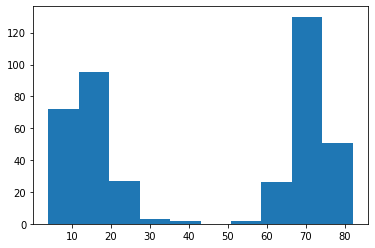

In [ ]:
from matplotlib import pyplot as plt
plt.hist([len(text.split()) for text in train_texts])
plt.show()

In [ ]:
import collections
import torch
label_vocab = collections.defaultdict(lambda: len(label_vocab))
MAXLEN = 80
batch_size = 32
hidden_size = 128
embed_size = 128
DEVICE = torch.device('cuda')

def prepare_texts(texts, labels):
  X = torch.LongTensor(len(texts), MAXLEN).fill_(tokenizer.pad_token_id)
  for i, text in enumerate(texts):
    indexed_tokens = bert_text_to_ids(text)
    length = min([MAXLEN, len(indexed_tokens)])
    X[i,:length] = indexed_tokens[:length]
  
  Y = torch.tensor(labels).long()
  return X.to(DEVICE), Y.to(DEVICE)

X_train, y_train = prepare_texts(train_texts, train_labels)
X_valid, y_valid = prepare_texts(valid_texts, valid_labels)
X_test, y_test = prepare_texts(test_texts, test_labels)

In [ ]:
print(X_train.shape, X_test.shape, X_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)

torch.Size([408, 80]) torch.Size([171, 80]) torch.Size([103, 80])
torch.Size([408, 19]) torch.Size([171, 19]) torch.Size([103, 19])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# RNN Classifier

## class RNN classifier 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
class RNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.decision = nn.Linear(1 * 2 * hidden_size, len(LABELS))
    self.to(DEVICE)
  
  def forward(self, x):
    embed = self.embed(x)
    output, hidden = self.rnn(embed) 
    drop = self.dropout(hidden.transpose(0, 1).reshape(x.shape[0], -1))
    return torch.softmax(self.decision(drop),1)

rnn_model = RNNClassifier()
with torch.no_grad():
  print(rnn_model(X_train[:3]).shape)

torch.Size([3, 19])


## Performance et entraînement RNN classifier 

Reprise du notebook sur litcovid pour les fonctions de performances et de fit en multi label

In [ ]:
def CrossEntropyLossOneHot(y_score=None, y=None):
    """CrossEntropy pour la multi classification
    """
    log_y_score = torch.log(y_score)
    cost = -torch.sum(y * log_y_score)
    return cost

def perf(model, loader, seuil:float=2e-1):
    """Evaluation en multi-label, le seuil désigne le niveau a partir duquel on considère une classe comme 'prédite'
    """
    criterion = CrossEntropyLossOneHot
    model.eval()
    total_loss = num = num_comp = correct = 0
    total_pred = true_y = None # concaténation des batchs
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = multi_hot(y_scores, seuil)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
            correct += torch.sum(y_pred == y).item()
            total_loss += loss.item()
            num_comp += len(y) * len(LABELS)
            num += len(y)

    f_score = f1_score(true_y.cpu(), total_pred.cpu(), average='micro')
    accu_score = accuracy_score(true_y.cpu(), total_pred.cpu())
    return total_loss / num, correct / num_comp, accu_score, f_score

In [ ]:
def multi_hot(y_pred, seuil=2e-1):
    """binarize prediction using threshold
    """
    res = torch.zeros(y_pred.shape[0], y_pred.shape[1])#.int()
    res[torch.arange(y_pred.shape[0]), torch.argmax(y_pred, dim=1)] = 1
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] > seuil:
                res[i,j] = 1
    return res.to(DEVICE)

In [ ]:
def fit_rnn(model, train_loader, epochs, lr=1e-3, seuil=2e-1): 
    criterion = CrossEntropyLossOneHot
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history  = {
        'train_losses' : [],
        'val_losses' : [],
        'preci' : [],
        'all_good_preci' : [],
        'f_micro' : [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)

        valloss, preci, accu_score, f_mesure = perf(model, valid_loader, seuil)
        history['train_losses'].append(total_loss / num)
        history['val_losses'].append(valloss)
        history['preci'].append(preci)
        history['all_good_preci'].append(accu_score)
        history['f_micro'].append(f_mesure)

        print(f'\nepoch : {epoch}\t - train loss : {total_loss / num}\t - val loss : {valloss}\t - precision :{preci}\t - all good precision : {accu_score}\t - f-score micro : {f_mesure}')

    return history

In [ ]:
history_rnnclassif = fit_rnn(rnn_model, train_loader, 10)

## Tests pour la paramétrisation

In [ ]:
def print_history_test(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    plt.figure()
    if losses:
      plt.subplot(131)
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
    
    if [f_micro]:
      plt.subplot(133)
      plt.plot(x,hist['f_micro'])
      plt.xlabel('Epoch')
      plt.ylabel('f_score mean')
      plt.show()


In [ ]:
lr_tab = np.array([ 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13])
seuil_tab = np.arange(0.,0.5,0.01)

max = 0.
lr_max = 0.
seuil_max = 0.

for seuil in seuil_tab:
  for lr in lr_tab:
    history = fit_rnn(rnn_model, train_loader, 3, lr=lr, seuil=seuil)
    titre = 'seuil : ' + str(seuil) + ' , lr : ' + str(lr)
    print(titre)
    # print_history_test(history)
    f_score = np.mean(history['f_micro'])
    if max < f_score:
      history_temp = history
      max = f_score
      lr_max = lr
      seuil_max = seuil

print("\n\n___________________________\n\n")
print("Meilleur f_score :", max, " avec un seuil de", seuil_max, " et un learning rate de", lr_max)
print_history_test(history_temp)


On obtient le meilleur f1-score (0.3766) avec:
* lr=1e-05
* seuil = 0.11

# BioBert Finetuning

In [ ]:
!pip install pandas==0.23
!pip install transformers==3.0.0

In [ ]:
from transformers import BertModel

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Importation du model Bert pré-entraîné et freeze d'un certains nombre de couches.

In [ ]:
bert = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')


#freeze des 6 premières couches 
modules = [bert.embeddings, *bert.encoder.layer[:6]] 
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

Définission de notre nouvelle architecture constituée du model Bert précédent suivi d'une couche linéaire, d'une couche relu, d'un dropout à 0.1, d'une couche linéaire, et pour finir on applique un softmax. (Plusieurs modèles ont été testés.)

In [ ]:
class BioBertClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.bert = bert
    ### ajout de qq couches supplémentaires
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.lin1 = nn.Linear(self.bert.config.hidden_size,512)
    self.lin2 = nn.Linear(512, len(LABELS))
    self.softmax = nn.Softmax(dim=1)

    self.to(DEVICE)

  def forward(self, x):
    _,output = self.bert(x, attention_mask = (x != tokenizer.pad_token_id).long())
    x = self.lin1(output)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.lin2(x)
    return self.softmax(x)

bert_model = BioBertClassifier()
with torch.no_grad():
  print(bert_model(X_train[:3]).shape)

torch.Size([3, 19])


Reprise des fonctions fit et perf du Notebook sur l'étude de litcovid.

In [ ]:
def multi_hot(y_pred, seuil=2e-1):
    """binarize prediction using threshold
    """
    res = torch.zeros(y_pred.shape[0], y_pred.shape[1])#.int()
    res[torch.arange(y_pred.shape[0]), torch.argmax(y_pred, dim=1)] = 1
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] > seuil:
                res[i,j] = 1
    return res.to(DEVICE)

def CrossEntropyLossOneHot(y_score=None, y=None):
    """CrossEntropy pour la multi classification
    """
    log_y_score = torch.log(y_score)
    cost = -torch.sum(y * log_y_score)
    return cost

def perf(model, loader, seuil:float=2e-1):
    """Evaluation en multi-label, le seuil désigne le niveau a partir duquel on considère une classe comme 'prédite'
    """
    criterion = CrossEntropyLossOneHot
    model.eval()
    total_loss = num = num_comp = correct = 0
    total_pred = true_y = None # concaténation des batchs
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = multi_hot(y_scores, seuil)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
            correct += torch.sum(y_pred == y).item()
            total_loss += loss.item()
            num_comp += len(y) * len(LABELS)
            num += len(y)

    f_score = f1_score(true_y.cpu(), total_pred.cpu(), average='micro')
    accu_score = accuracy_score(true_y.cpu(), total_pred.cpu())
    return total_loss / num, correct / num_comp, accu_score, f_score

In [ ]:
def fit(model, epochs, train_loader, 
          lrbio:float=1e-4, lrdeci:float=1e-02, 
          freezebio:bool=True, 
          seuil:float=2e-1):
    criterion = CrossEntropyLossOneHot

    #freeze biobert layers
    if freezebio :
      for parameter in model.parameters():
          parameter.requires_grad = False
      for name, param in model.named_parameters():
          if 'decision' in name:
              param.requires_grad = True
      optimizer = optim.Adam(model.parameters(), lr=lrdeci)

    #different lr pour bio et decision
    else :
      my_list = ['decision.weight', 'decision.bias']
      params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))))
      base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))))
      optimizer = optim.Adam([{'params': base_params}, {'params': params, 'lr': lrdeci}], lr=lrbio)
      
    history  = {
        'train_losses' : [],
        'val_losses' : [],
        'preci' : [],
        'all_good_preci' : [],
        'f_micro' : [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)

        valloss, preci, accu_score, f_mesure = perf(model, valid_loader, seuil)
        history['train_losses'].append(total_loss / num)
        history['val_losses'].append(valloss)
        history['preci'].append(preci)
        history['all_good_preci'].append(accu_score)
        history['f_micro'].append(f_mesure)

        print(f'\nepoch : {epoch}\t - train loss : {total_loss / num}\t - val loss : {valloss}\t - precision :{preci}\t - all good precision : {accu_score}\t - f-score micro : {f_mesure}')

    return history

## Tests pour la paramétrisation de l'entraînement

In [ ]:
def print_history_test(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    plt.figure()
    if losses:
      plt.subplot(131)
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
    
    if [f_micro]:
      plt.subplot(133)
      plt.plot(x,hist['f_micro'])
      plt.xlabel('Epoch')
      plt.ylabel('f_score mean')
      plt.show()


In [ ]:
lrbio_tab = np.array([ 1e-04, 1e-05, 1e-06, 1e-07, 1e-08])
lrdeci_tab = np.array([ 1e-05, 1e-06, 1e-07, 1e-08, 1e-09])
seuil_tab = np.arange(0.,0.5,0.02)
print(len(seuil_tab))
max = 0.
lrbio_max = 0.
lrdeci_max = 0.
seuil_max = 0.

for seuil in seuil_tab:
  for lrbio in lrbio_tab:
    for lrdeci in lrdeci_tab:
      history = fit(bert_model, 3, train_loader, lrbio=3e-06, lrdeci=1e-07, freezebio=False, seuil=seuil)
      titre = 'seuil : ' + str(seuil) + ' , lrbio : ' + str(lrbio) + ' , lrdeci : ' + str(lrdeci)
      print(titre)
      # print_history_test(history)
      f_score = np.mean(history['f_micro'])
      if max < f_score:
        history_temp = history
        max = f_score
        lrbio_max = lrbio
        lrdeci_max = lrdeci
        seuil_max = seuil


print("Meilleur f_score : ", max, "avec seuil = ", seuil_max, ", lrbio = ", lrbio_max, " et lrdeci = ", lrdeci_max)
print_history_test(history_temp)


=> Avec ce test, meilleure performance (f1_score=0.599) avec :</br>
- seuil : 0.24 </br>
- lrbio : 1e-4 </br>
- lrdeci : 1e-09

# Comparaison RNNClassifier et Fine tuning BioBert

## Entraînement

Reprise de la fonction 'print_history' du Notebook sur l'étude des données Litcovid

In [ ]:
def print_history(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    """
    Génération des graphes d'entrainement avec les données extraites lors du fit (losses, etc). Possibilité de ne générer que certains des graphes.

    hist: dict
        résultat de la fonction fit
    """
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    if losses:
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
      plt.show()
    
    for (cond, name, label) in (zip([preci, all_good_preci, f_micro],
                          ['preci', 'all_good_preci', 'f_micro'],
                          ['Precision pour chaque label séparement', 'Precision pour l\'ensemble des labels', 'F-score micro'])):
        if cond:
            plt.plot(x,hist[name])
            plt.xlabel('Epoch')
            plt.ylabel(label)
            # plt.legend()
            plt.show()


  
# print_history(history)

100%|██████████| 13/13 [00:00<00:00, 103.66it/s]


epoch : 0	 - train loss : 1.777312157200832	 - val loss : 3.763303219693378	 - precision :0.86152273888605	 - all good precision : 0.10679611650485436	 - f-score micro : 0.34698795180722897



100%|██████████| 13/13 [00:00<00:00, 104.38it/s]


epoch : 1	 - train loss : 1.7771306505390243	 - val loss : 3.7615070713376535	 - precision :0.8630556974961676	 - all good precision : 0.10679611650485436	 - f-score micro : 0.3526570048309179



100%|██████████| 13/13 [00:00<00:00, 101.53it/s]


epoch : 2	 - train loss : 1.7588333055084826	 - val loss : 3.7606741155235515	 - precision :0.8635666836995401	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3535108958837772



100%|██████████| 13/13 [00:00<00:00, 104.87it/s]


epoch : 3	 - train loss : 1.742662644853779	 - val loss : 3.760977661725387	 - precision :0.8650996423096576	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3497536945812808



100%|██████████| 13/13 [00:00<00:00, 107.09it/s]


epoch : 4	 - train loss : 1.727203976874258	 - val loss : 3.7623041023328465	 - precision :0.8666326009197751	 - all good precision : 0.11650485436893204	 - f-score micro : 0.35555555555555557



100%|██████████| 13/13 [00:00<00:00, 94.34it/s]


epoch : 5	 - train loss : 1.7353933278252096	 - val loss : 3.7643730385789596	 - precision :0.8686765457332652	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3558897243107769



100%|██████████| 13/13 [00:00<00:00, 105.18it/s]


epoch : 6	 - train loss : 1.7131745488035912	 - val loss : 3.7671435087629894	 - precision :0.8702095043433827	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3553299492385787



100%|██████████| 13/13 [00:00<00:00, 102.51it/s]


epoch : 7	 - train loss : 1.7196849187215169	 - val loss : 3.7696408392156213	 - precision :0.8702095043433827	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3553299492385787



100%|██████████| 13/13 [00:00<00:00, 107.02it/s]


epoch : 8	 - train loss : 1.7054100597605986	 - val loss : 3.7727800387780643	 - precision :0.8717424629535002	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35805626598465473



  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 9	 - train loss : 1.6894552847918343	 - val loss : 3.7754258831727854	 - precision :0.8712314767501278	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3538461538461538


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 3.860508208181344	 - val loss : 3.787848963320834	 - precision :0.9059785385794583	 - all good precision : 0.21359223300970873	 - f-score micro : 0.2868217054263566


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 3.4544777963675704	 - val loss : 3.711191510691226	 - precision :0.9080224833929484	 - all good precision : 0.22330097087378642	 - f-score micro : 0.3129770992366412


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 3.2227298325183344	 - val loss : 3.618230245645764	 - precision :0.9064895247828308	 - all good precision : 0.21359223300970873	 - f-score micro : 0.34408602150537637


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 3	 - train loss : 2.9534549713134766	 - val loss : 3.512668517029401	 - precision :0.9039345937659683	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3380281690140845


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 4	 - train loss : 2.631520897734399	 - val loss : 3.238971043558954	 - precision :0.9187531936637711	 - all good precision : 0.2815533980582524	 - f-score micro : 0.42181818181818187


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 5	 - train loss : 2.27738608565985	 - val loss : 3.0551765219679154	 - precision :0.9279509453244762	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5052631578947369


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 6	 - train loss : 1.9616287175346823	 - val loss : 2.9738393246548847	 - precision :0.9340827797649464	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 7	 - train loss : 1.7183805727491193	 - val loss : 2.8120592172863415	 - precision :0.9335717935615738	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 8	 - train loss : 1.5849528780170516	 - val loss : 3.043532751138928	 - precision :0.9294839039345938	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5369127516778522


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]



epoch : 9	 - train loss : 1.460316774891872	 - val loss : 3.2530644240888575	 - precision :0.9279509453244762	 - all good precision : 0.2815533980582524	 - f-score micro : 0.5346534653465346


___________________________




Comparaison générale


* * * RNNClassifier * * * 
 f-score :  0.3538461538461538


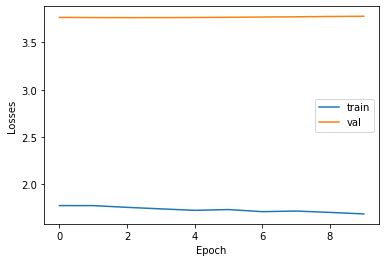

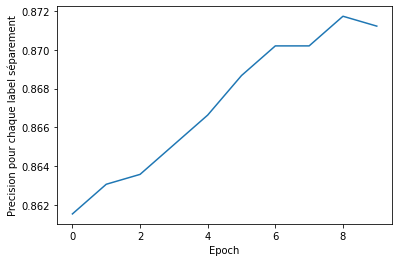

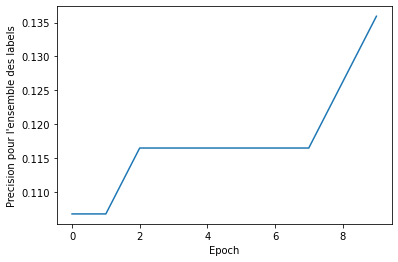

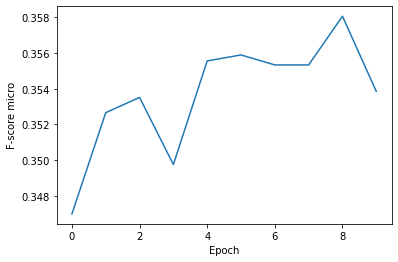



* * * Fine tuning Bert * * *
 f-score :  0.5346534653465346


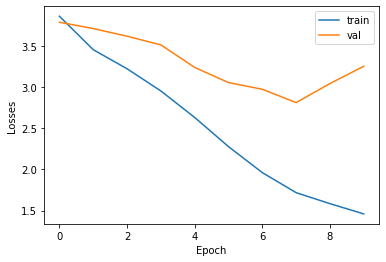

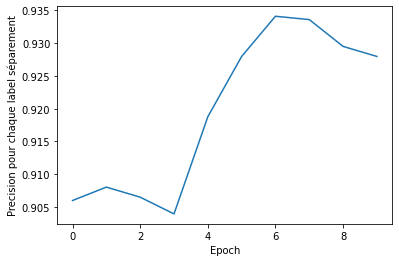

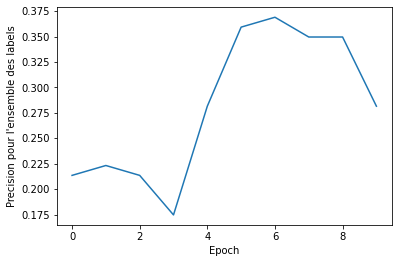

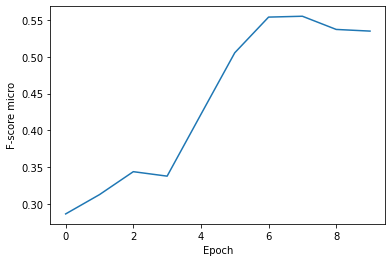

In [ ]:
##RNN Classifier :
seuil = 0.11
lr = 1e-5
history_rnnclassif = fit_rnn(rnn_model, train_loader, 10, lr=lr, seuil=seuil)

##Fine tuning BioBERT :
seuil = 0.24
lr_bio = 1e-04
lr_deci = 1e-09

history_bert = fit(bert_model, 10, train_loader, lrbio=lr_bio, lrdeci=lr_deci, freezebio=False, seuil=seuil)


print("\n\n___________________________\n\n")
print("\n\nComparaison générale\n\n")
print('* * * RNNClassifier * * * ')
print(" f-score : ", history_rnnclassif['f_micro'][9])
print_history(history_rnnclassif)
print('\n\n* * * Fine tuning Bert * * *')
print(" f-score : ", history_bert['f_micro'][9])
print_history(history_bert)


## Test

In [ ]:
test_loss, test_preci, accu_score, f_score = perf(rnn_model, test_loader, seuil=0.11)
print('RNN Classifier -','test loss :', test_loss, '- precision :', test_preci, '- all good precision :', accu_score, '- f-score micro :', f_score)
test_loss, test_preci, accu_score, f_score = perf(bert_model, test_loader, seuil=0.24)
print('BioBERT -','test loss :', test_loss, '- precision :', test_preci, '- all good precision :', accu_score, '- f-score micro :', f_score)

RNN Classifier - test loss : 3.624749992325989 - precision : 0.883964296706679 - all good precision : 0.07017543859649122 - f-score micro : 0.43982169390787523
BioBERT - test loss : 2.9973252056634916 - precision : 0.9372114496768237 - all good precision : 0.3567251461988304 - f-score micro : 0.5887096774193549


# Conclusion

Les performances avec le model Bert sont meilleurs qu'avec le model Rnn Classifier. On peut supposer que le manque de données explique les résultats si faible. Pour la prédiction de spécialité c'est le modèle BioBert qui obtient le meilleur f1-score (0.58). 